In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy
import pickle
import time
from typing import Sequence

import matplotlib.pyplot as plt
import numpy as np
import torch

from janelia_core.visualization.image_generation import generate_dot_image_3d
from janelia_core.visualization.volume_visualization import signed_max_proj

from sparse_networks import CenteredBumpFcn
from sparse_networks import FunctionSequenceGenerator
from sparse_networks import plot_2d_f
from sparse_networks import SumOfBumpFcns


Unable to import moviepy.  Minor functionality will not be available.


In [3]:
%matplotlib notebook

## Define objects

In [4]:
class PWL_NNNetwork(torch.nn.Module):
    """ Piecewise linear nearest neighbor network"""
    
    def __init__(self, init_centers: torch.Tensor, init_weights: torch.Tensor, 
                 init_offsets: torch.Tensor, k: int = 1):
        """ Creates a new PWL_NNNetwork. 
        
        Args:
                
            init_centers: Initial centeres for each function. Of shape n_ctrs*input_dim
            
            init_weights: Initial weights for each function. Of shape n_ctrs*input_dim
            
            init_offsets: Initial offsets for each function. Of length n_ctrs
                      
            k: Number of nearest neighbors to use. 
        """
        
        super().__init__()
        
        self.k = k
        self.n_fcns = init_centers.shape[0]
        self.d_in = init_centers.shape[1]
             
        self.ctrs = torch.nn.Parameter(init_centers)
        #self.register_buffer('ctrs', init_centers)
        self.wts = torch.nn.Parameter(init_weights)
        self.offsets = torch.nn.Parameter(init_offsets)
        
    def get_nearest_neigbors(self, x:torch.Tensor) -> torch.Tensor:
        
        # Find the k closest centers to each data point
        with torch.no_grad():
            ctrs_expanded = torch.reshape(self.ctrs, [self.n_fcns, 1, self.d_in])
            diffs = x - ctrs_expanded
            sq_distances = torch.sum(diffs**2, dim=2)
            top_k_indices = torch.topk(-sq_distances, k=self.k, dim=0).indices
            
        return top_k_indices
    
    def forward(self, x: torch.Tensor):
        """ Computes output from input. 
        
        Args:
        
            x: Input of shape n_smps*input_dim
            
        Returns: 
            y: Output of shape n_smps*output_dim
        """


        top_k_indices = self.get_nearest_neigbors(x)
            
        # Compute linear functions applied to each input data point
        selected_wts = self.wts[top_k_indices]
        selected_ctrs = self.ctrs[top_k_indices]
        
        applied_wts = torch.sum(selected_wts, dim=0)
        applied_offsets = (torch.sum(self.offsets[top_k_indices], dim=0) - 
                           torch.sum(torch.sum(selected_wts*selected_ctrs, dim=0), dim=1))
        
        return torch.sum(applied_wts*x, dim=1) + applied_offsets
    
    def bound(self, ctr_bounds: Sequence = [0, 1], bound_fcns: bool =  True):
        """  Applies bounds to the centers.

        Bounds are applied element-wise.

        Args:

            ctr_bounds: The bounds to force centers to be between. If None, no bounds are enforced.
            
            bound_fcns: True if bound should be called on functiions. 

        """

        if ctr_bounds is not None:
            small_inds = self.ctrs < ctr_bounds[0]
            big_inds = self.ctrs > ctr_bounds[1]
            self.ctrs.data[small_inds] = ctr_bounds[0]
            self.ctrs.data[big_inds] = ctr_bounds[1]


## Fitting function

In [5]:
def fit(nn: torch.nn.Module, x: torch.Tensor, y: torch.Tensor, n_its = 1000, lr=.01, batch_size: int = None, 
        enforce_bounds: bool = True, update_int: int = 1000):
    """ Fits a neural network. 
    
    Args:
        x: Input data of shape n_smps*d_in
        
        y: Output data of shape n_smps*1
        
        n_its: The number of iterations to run optimization for
        
        lr: The learning rate to use
        
        enforce_bounds: If true, the center of bump functions will be
        constrained to stay in the unit hypercube
        
        update_int: Interval updates are printed
    
    """
    
    params = nn.parameters()
    
    optimizer = torch.optim.Adam(params = params, lr=lr)
    
    n_smps = x.shape[0]
    if batch_size is None:
        batch_size = n_smps
    
    for i in range(n_its):
        
        # Select samples for this iteration 
        if batch_size != n_smps:
            inds = torch.randperm(n_smps)[1:batch_size]
            batch_x = x[inds, :]
            batch_y = y[inds]
        else:
            batch_x = x
            batch_y = y
        
        optimizer.zero_grad()
        
        y_pred = nn(batch_x)
        er = torch.sum((batch_y - y_pred)**2)/batch_size
        er.backward()
        
        optimizer.step()
        
        if enforce_bounds:
            nn.bound()
        
        if i % update_int == 0:
            er_log = float(er.detach().cpu().numpy())
            print('It ' + str(i) +  ': {:e}'.format(er_log))
    

## Load data to fit

In [6]:
tgt_file = r'/groups/bishop/bishoplab/scratch/results/tgt_mode.pkl'

In [7]:
with open(tgt_file, 'rb') as f:
    tgt_data = pickle.load(f)

In [8]:
x = tgt_data['inflated_neuron_locations'].data
y = tgt_data['tgt_mode'].data.squeeze()

## Fit a function to the data

In [35]:
run_on_gpu = True
n_fcns = 10000
k = 1

In [36]:
x_mins = torch.min(x, dim=0).values
x_maxs = torch.max(x, dim=0).values
x_range = x_maxs - x_mins

init_center_inds = np.round(np.linspace(0, x.shape[0], n_fcns)).astype('int')
init_center_inds[init_center_inds == x.shape[0]] = x.shape[0] - 1
init_center_inds = torch.Tensor(init_center_inds).long()

init_centers = copy.deepcopy(x[init_center_inds])
init_weights = .001*torch.randn(n_fcns, 3)
init_offsets = torch.zeros(n_fcns)

fit_f = PWL_NNNetwork(init_centers=init_centers, init_weights=init_weights, init_offsets=init_offsets, k=k)

In [37]:
if run_on_gpu:
    fit_f.to('cuda')
    x = x.to('cuda')
    y = y.to('cuda')
else:
    fit_f.to('cpu')
    x = x.to('cpu')
    y = y.to('cpu')

In [38]:
lr = .001
enforce_bounds=False
batch_size = x.shape[0]

t0 = time.time()

fit(fit_f, x, y, n_its = 300, lr=lr, batch_size=batch_size, enforce_bounds=enforce_bounds, update_int=50)
    
t_stop = time.time()

print('Elapsed time: ' + str(t_stop - t0))

It 0: 2.124062e-04
It 50: 1.603231e-05
It 100: 1.521916e-05
It 150: 1.517856e-05
It 200: 1.516772e-05
It 250: 1.516331e-05
Elapsed time: 97.60015392303467


## Look at scatter plot of true vs learned coefficients

In [39]:
fit_f.to('cpu')
x = x.to('cpu')
y = y.to('cpu')

In [40]:
y_true = y.cpu().numpy()
y_est = fit_f(x).cpu().detach().numpy()

<IPython.core.display.Javascript object>


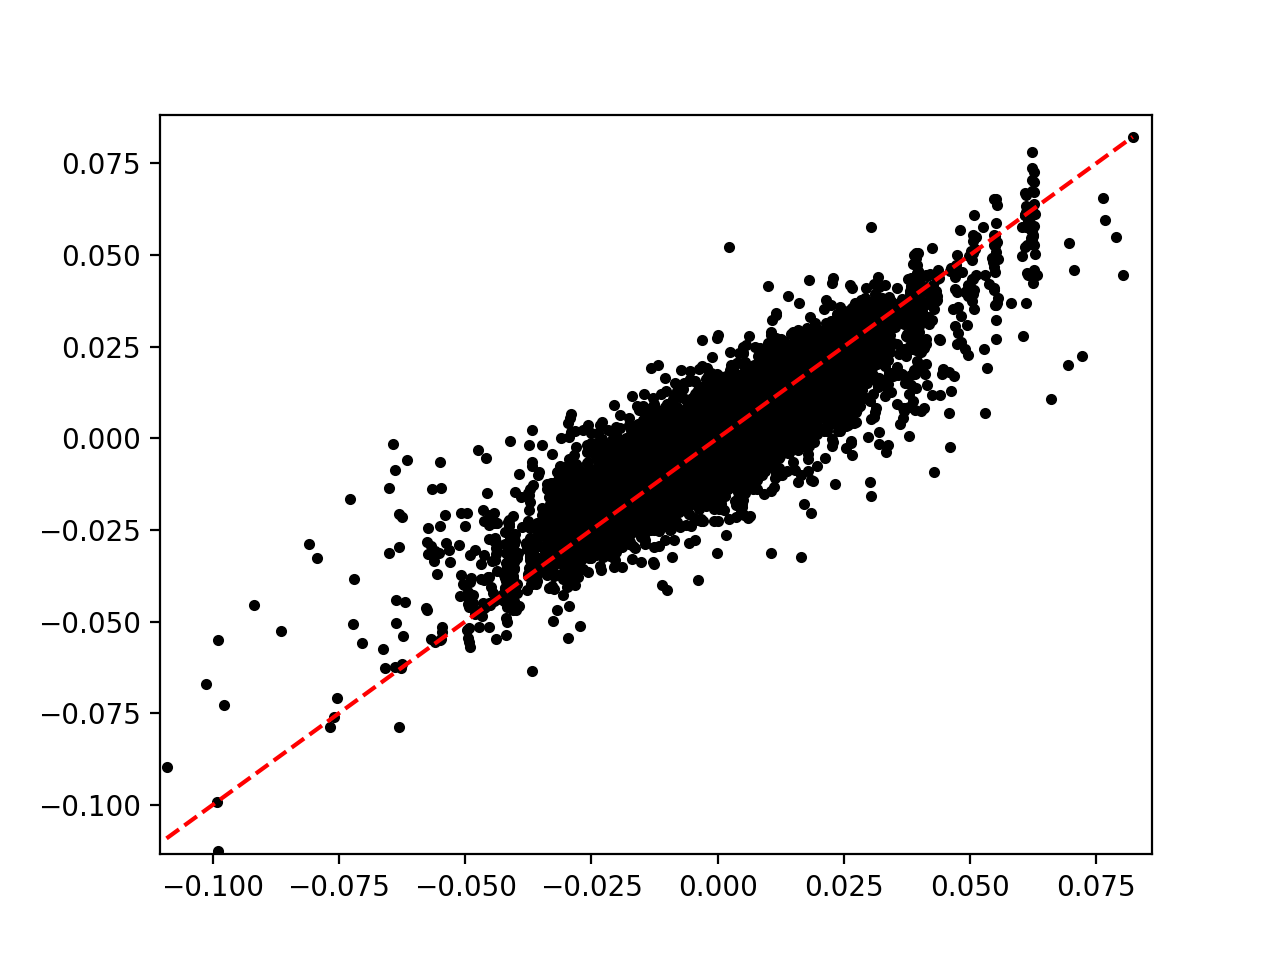

In [41]:
plt.figure()
plt.plot(y_true, y_est, 'k.')

min_y_true = np.min(y_true)
max_y_true = np.max(y_true)

plt.plot([min_y_true, max_y_true], [min_y_true, max_y_true], 'r--')

## Look at where our centers are

In [42]:
ctrs = fit_f.ctrs.cpu().data.numpy()

<IPython.core.display.Javascript object>


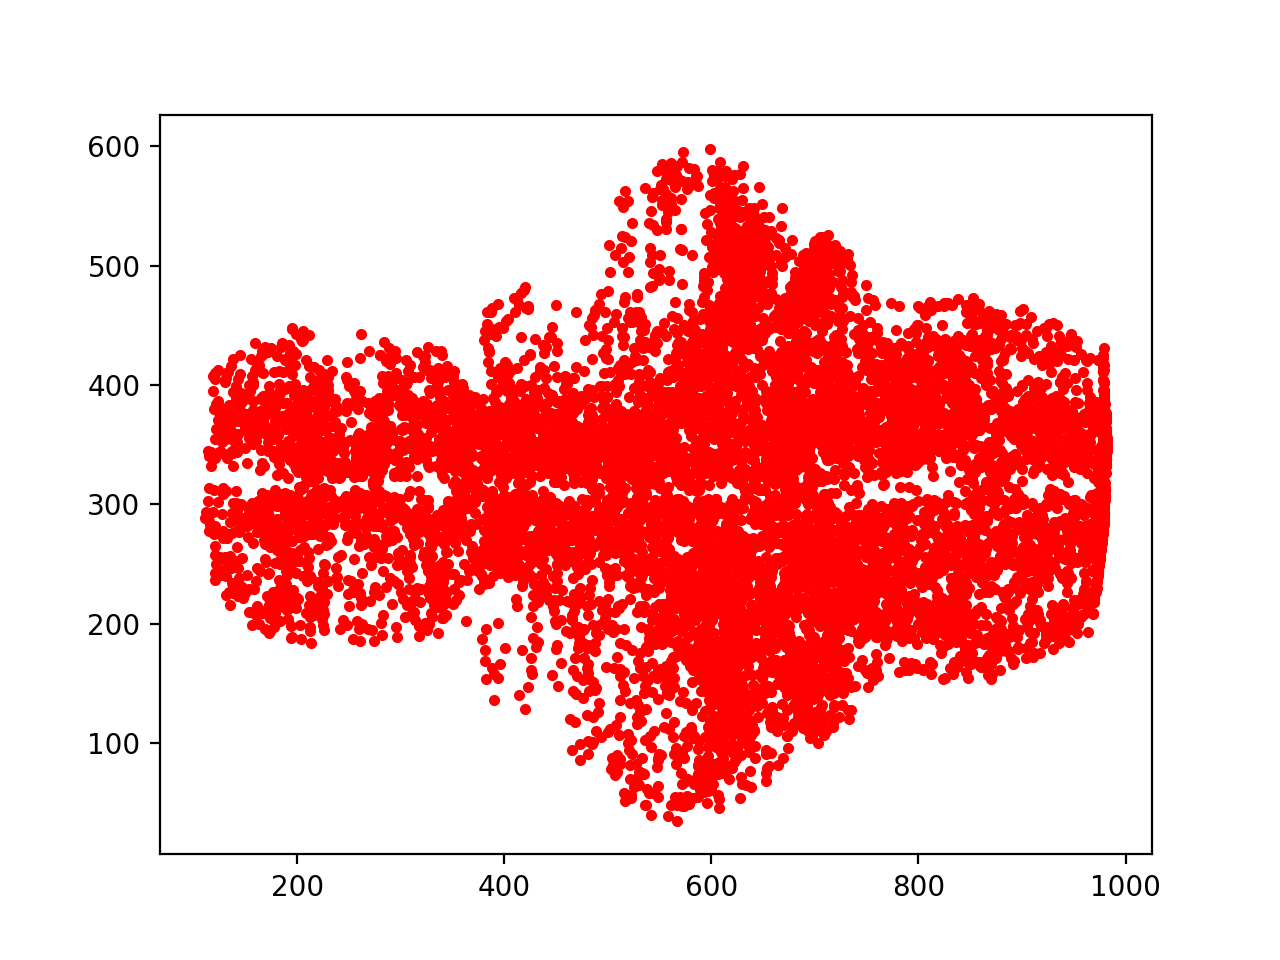

In [43]:
plt.figure()
plt.plot(ctrs[:,0], ctrs[:,1], 'r.')

## Visualize true and estimated modes

In [44]:
x_plot = copy.deepcopy(x).cpu().numpy()
x_plot[:,2] = x_plot[:,2]/tgt_data['z_ratio']

true_vls = copy.deepcopy(y).cpu().numpy()
est_vls = y_est

im_shape = copy.deepcopy(x_maxs.numpy())
im_shape[2] = im_shape[2]/tgt_data['z_ratio']
im_shape = im_shape + 1
im_shape = im_shape.astype('int')

In [45]:
true_mode_im = generate_dot_image_3d(image_shape=im_shape,
                                                dot_ctrs=x_plot,
                                                dot_vls=true_vls,
                                                ellipse_shape = [5, 5, 1])

In [46]:
est_mode_im = generate_dot_image_3d(image_shape=im_shape,
                                                dot_ctrs=x_plot,
                                                dot_vls=est_vls,
                                                ellipse_shape = [5, 5, 1])

<IPython.core.display.Javascript object>


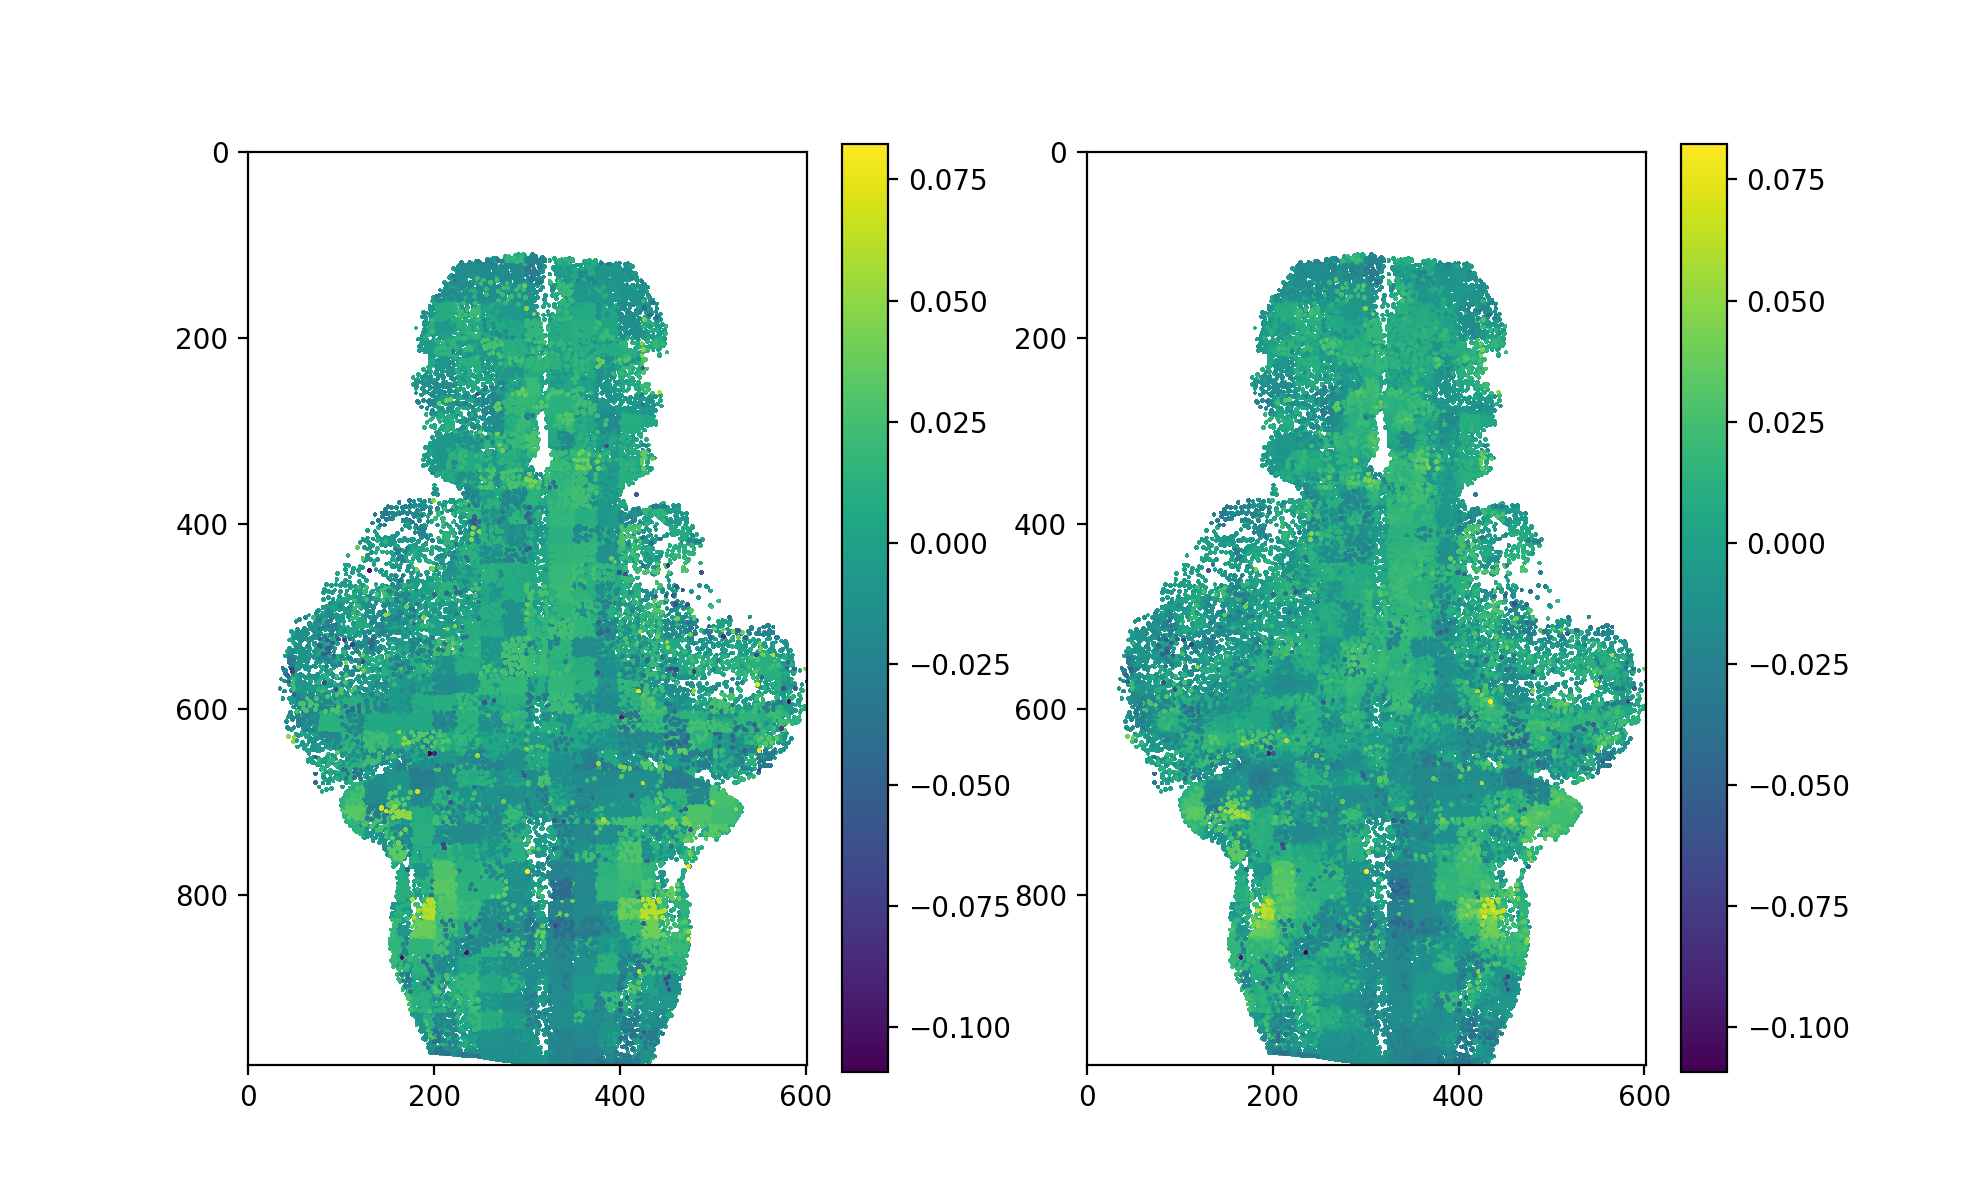

In [47]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(signed_max_proj(true_mode_im, dim=2))
clim = vmin, vmax = plt.gci().get_clim()
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(signed_max_proj(est_mode_im, dim=2), clim=clim)
plt.colorbar()